# PCBO: Preferential Causal Bayesian Optimisation
## Generic Graph


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.preprocessing import StandardScaler
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

# Custom modules
from flows import real_nvp, neural_spline_flow, create_base_distribution
from prefflow import PrefFlow
from pcbo_dataset import PCBO_Dataset_Three, PCBO_Dataset_Six, PCBO_ERDataset, PCBO_MedicalDataset
from parent_posterior import LocalParentPosterior, greedy_map_dag_from_edge_matrix
from parent_posterior_scalable import ScalableLocalParentPosterior
from acquisition import pig_pairwise, eeig_pairwise
from dag_visual import plot_dag

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

# Device and precision
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
precision_double = True
print(f"Using device: {device}")

Using device: cpu


## Problem Setup

In [2]:
"""
Toy Problem: X1 -> Y <- X2
- We can intervene on X1, X2, or Y
- True utility: minimize |Y| with small intervention cost
- Learn both the causal graph and utility function from preferences
"""

# Problem parameters
d_utility = 2  # Dimensionality for utility function input
n_initial_prefs = 20  # Initial preference data
n_iterations = 50  # PCBO iterations
k = 2  # k-wise preferences (pairwise)
flow_layers = 5  # Number of flow layers in the PrefFlow
flow_type = "real_nvp"  # "real_nvp" or "neural_spline"

# Create synthetic dataset
dataset = PCBO_Dataset_Six(
    n_queries=n_initial_prefs,
    noise_std=0.1,
    domain=(-2, 2),
    seed=42
)
print(f"Testing on {dataset.n_nodes}-node graph")

n_nodes = dataset.n_nodes  # Number of nodes in the causal graph
y_idx = n_nodes - 1  # Index of the target variable Y

true_adj, node_names = dataset.get_causal_graph()
print("------------------------")
print(f"True causal graph:\n{true_adj}")
print(f"Node names: {node_names}")

Testing on 6-node graph
------------------------
True causal graph:
tensor([[0, 0, 0, 1, 0, 1],
        [0, 0, 0, 0, 0, 1],
        [0, 0, 0, 1, 0, 1],
        [0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]])
Node names: ['X1', 'X2', 'X3', 'X4', 'X5', 'Y']


## Helper Classes and Functions

In [3]:
class PreferenceDataset:
    """Storage for preference comparisons"""
    def __init__(self, device):
        self.device = device
        self.feature_pairs = []  # List of (feat_winner, feat_loser) tuples
        self.labels = []  # List of labels (always 1.0 for winner first)
        self._X_cache = None
        self._Y_cache = None
        self._cache_valid = False
        
    def add_preference(self, outcome_winner, outcome_loser):
        """Add a new preference comparison"""
        feat_winner = intervention_to_utility_features(outcome_winner)
        feat_loser = intervention_to_utility_features(outcome_loser)
        self.feature_pairs.append((feat_winner, feat_loser))
        self.labels.append(1.0)
        self._cache_valid = False
        
    def add_from_query(self, query_data):
        """Add preferences from a query with k options"""
        outcomes = query_data['outcomes']
        winner_idx = query_data['winner_idx']
        
        # Compare winner against all losers
        for i in range(len(outcomes)):
            if i != winner_idx:
                self.add_preference(outcomes[winner_idx], outcomes[i])
        
    def get_batch(self, last_n=None):
        """Get preference data in PrefFlow format"""
        if len(self.feature_pairs) == 0:
            return None, None
            
        pairs = self.feature_pairs[-last_n:] if last_n else self.feature_pairs
        labels = self.labels[-last_n:] if last_n else self.labels
        
        n_comparisons = len(pairs)
        feat_dim = pairs[0][0].shape[0]
        X = torch.zeros(2, feat_dim, n_comparisons).to(self.device)
        
        for i, (feat1, feat2) in enumerate(pairs):
            X[0, :, i] = feat1.to(self.device)
            X[1, :, i] = feat2.to(self.device)
        
        Y = torch.tensor(labels, dtype=torch.float32).to(self.device)
        
        return X, Y
    
    def __len__(self):
        return len(self.feature_pairs)

def intervention_to_utility_features(intervention_outcome):
    """
    Map intervention outcomes to features for utility function
    Normalized to prevent numerical issues
    """
    if not isinstance(intervention_outcome, torch.Tensor):
        intervention_outcome = torch.tensor(intervention_outcome, dtype=torch.float32)
    
    # Determine which node is Y 
    y_value = intervention_outcome[y_idx]
        
    y_normalized = torch.tanh(y_value / 2.0)  # Assuming Y is roughly in [-2, 2]

    # Fixed intervention cost (also normalized)
    intervention_cost = 0.1
    
    # Match the dtype of the flow
    dtype = torch.float64 if precision_double else torch.float32
    
    features = torch.tensor([
        y_normalized.item() if isinstance(y_normalized, torch.Tensor) else y_normalized,
        intervention_cost
    ], dtype=dtype)
    
    return features

# Map a full outcome vector to (x_for_graph, y) for the ParentPosterior
def outcome_to_xy_local(outcome, lpp):
    x = outcome[lpp.parent_idx].unsqueeze(0)
    y = outcome[lpp.target_idx].reshape(1, 1)
    return x, y

# Helper to create locals for all targets except Y
def make_all_local_posts(n_nodes, y_idx=5):
    locals_dict = {}
    
    if n_nodes > 10:
        # Use MCMC-based scalable version
        PostClass = ScalableLocalParentPosterior
        print(f"Using scalable MCMC posterior for {n_nodes} nodes")
    else:
        # Use exact enumeration
        PostClass = LocalParentPosterior
        
    for t in range(n_nodes):
        if t == y_idx:
            parent_idx = [i for i in range(n_nodes) if i != y_idx]
            pi = 0.15
        else:
            parent_idx = [i for i in range(n_nodes) if i != t and i != y_idx]
            pi = 0.05
            
        kwargs = {
            'parent_idx': parent_idx,
            'target_idx': t,
            'a0': 2.0,
            'b0': 2.0,
            'tau2': 0.25,
            'prior_sparsity': pi,
            'device': device,
            'dtype': torch.float64
        }
        
        if n_nodes > 10:
            kwargs['max_parents'] = min(5, n_nodes - 1)
            
        locals_dict[t] = PostClass(**kwargs)
        
    return locals_dict

## DAG Constraint Functions

In [4]:
def is_dag(adj):
    """Check if adjacency matrix represents a DAG"""
    n = adj.shape[0]
    A = adj.astype(float)
    A_power = np.eye(n)
    for _ in range(n):
        A_power = A_power @ A
        if np.trace(A_power) > 0:
            return False
    return True

def get_dag_adjacency(pcbo):
    """Get learned adjacency and ensure it's a DAG"""
    n = pcbo.n_nodes if hasattr(pcbo, 'n_nodes') else len(pcbo.local_posts)
    adj_weighted = np.zeros((n, n))
    
    for target, lp in pcbo.local_posts.items():
        if lp.num_datapoints() >= 2:
            lp.update_posterior()
            probs = lp.edge_posterior()
            if torch.is_tensor(probs):
                probs = probs.cpu().numpy()
                
            for i, parent_idx in enumerate(lp.parent_idx):
                adj_weighted[parent_idx, target] = probs[i]
    
    # Threshold to get binary adjacency
    adj = (adj_weighted > 0.5).astype(int)
    
    # Check if it's already a DAG
    if is_dag(adj):
        return adj
        
    # If not, remove edges to make it a DAG
    print("  Graph has cycles, projecting to DAG...")
    
    # Strategy: Remove edges based on weight (keep stronger edges)
    edges = []
    for i in range(n):
        for j in range(n):
            if adj[i, j]:
                edges.append((adj_weighted[i, j], i, j))
    
    # Sort edges by weight (descending)
    edges.sort(reverse=True)
    
    # Add edges one by one, skip if creates cycle
    dag = np.zeros((n, n), dtype=int)
    for weight, i, j in edges:
        dag[i, j] = 1
        if not is_dag(dag):
            dag[i, j] = 0  # Remove if creates cycle
            
    return dag

## PCBO Main Class

In [5]:
class PCBO:
    def __init__(self, dataset, device, n_iterations=50, flow_type="real_nvp", y_idx=y_idx):
        self.dataset = dataset
        self.device = device
        self.n_iterations = n_iterations
        self.flow_type = flow_type
        self.n_nodes = dataset.n_nodes
        self.y_idx = y_idx

        # Initialize components
        self.pref_flow = self._create_flow(flow_type)
        
        # Keep track of all local parent posteriors
        self.local_posts = make_all_local_posts(self.dataset.n_nodes, y_idx=self.y_idx)
        self.parent_posterior = self.local_posts[self.y_idx]  # Keep a convenience handle for Y

        # Get true adjacency matrix
        self.true_adj, self.node_names = dataset.get_causal_graph()
        
        # Efficient preference storage
        self.pref_dataset = PreferenceDataset(device)

        # DAG constraint tracking
        self.current_dag = None

        # Identify controllable nodes (all except Y)
        self.controllable = [i for i in range(self.n_nodes) if i != self.y_idx]

        # Storage for tracking progress
        self.iteration_history = []
        self.graph_distances = []
        self.utility_errors = []
        self.edge_prob_errors = []
        self.selected_interventions = []
        self.causal_buffer = []  # Buffer for causal updates
        
        # Stability tracking
        self.flow_stable = True
        self.instability_count = 0
        self.reinitialization_count = 0
        
    def _create_flow(self, flow_type="real_nvp"):
        """Create a fresh PrefFlow model"""
        # Local precision setting for this flow
        local_precision = precision_double
        
        # Neural spline doesn't support double precision
        if flow_type == "neural_spline":
            local_precision = False
            
        base_dist = create_base_distribution(d_utility, self.device, local_precision)
        
        if flow_type == "neural_spline":
            nf_model = neural_spline_flow(
                K=max(2, flow_layers // 2),  # Fewer layers for stability
                D=d_utility,
                q0=base_dist,
                device=self.device,
                precision_double=False,  # Force False
                hidden_layers=2,
                hidden_units=64
            )
            # Override the precision_double attribute for PrefFlow
            flow_precision = False
        else:
            # Default to RealNVP (supports double precision)
            nf_model = real_nvp(flow_layers, d_utility, base_dist, self.device, precision_double)
            flow_precision = precision_double

        s_init = 1.0
        pref_flow = PrefFlow(nf_model, s_init, d_utility, ranking=False, 
                            device=self.device, precision_double=flow_precision)
        return pref_flow
        
    def train_utility_on_preferences(self, n_epochs=50, lr=1e-3, batch_size=None):
        """
        Train PrefFlow based on preference data
        """
        # Use all available data if batch_size not specified
        if batch_size is None:
            batch_size = min(40, len(self.pref_dataset))
        
        # Get data from preference dataset
        X, Y = self.pref_dataset.get_batch(last_n=batch_size)
        if X is None or Y is None:
            print("    No preference data available")
            return []
        
        base_lr = lr
        param_groups = [
            {"params": [p for n,p in self.pref_flow.named_parameters() if n != "s_raw"],
             "lr": base_lr, "weight_decay": 1e-5},
            {"params": [self.pref_flow.s_raw],
             "lr": base_lr * 2, "weight_decay": 0.0},
        ]
        optimizer = torch.optim.Adam(param_groups)

        # Cosine annealing scheduler
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs, eta_min=1e-5)
        
        losses = []
        best_loss = float("inf")
        patience = 10
        patience_counter = 0

        for epoch in range(n_epochs):
            optimizer.zero_grad()
            
            try:
                # Compute loss
                log_posterior = self.pref_flow.logposterior((X, Y))
                
                # Check for NaN
                if torch.isnan(log_posterior) or torch.isinf(log_posterior):
                    self.flow_stable = False
                    self.instability_count += 1
                    
                    if self.instability_count > 3:
                        print(f"    Flow unstable, reinitializing...")
                        self._reinitialize_flow()
                        return self.train_utility_on_preferences(n_epochs//2, lr*0.5, batch_size)
                    continue

                loss = -log_posterior / batch_size

                # Only backprop if loss is valid and reasonable
                if not torch.isnan(loss) and not torch.isinf(loss) and abs(loss.item()) < 1e4:
                    loss.backward()
                    
                    # Gradient clipping for stability
                    torch.nn.utils.clip_grad_norm_(self.pref_flow.parameters(), max_norm=5.0)
                    
                    optimizer.step()
                    scheduler.step()
                    losses.append(loss.item())
                    
                    # Reset instability count on successful training
                    self.flow_stable = True
                    self.instability_count = 0

                    # Early stopping
                    if loss.item() < best_loss:
                        best_loss = loss.item()
                        patience_counter = 0
                    else:
                        patience_counter += 1
                        if patience_counter >= patience:
                            print(f"    Early stopping at epoch {epoch}")
                            break
                    
                    if epoch % 20 == 0:
                        current_lr = scheduler.get_last_lr()[0]
                        print(f"    Epoch {epoch}, Loss: {loss.item():.4f}, LR: {current_lr:.4f}")

            except Exception as e:
                print(f"    Error during training: {e}")
                self.instability_count += 1
                if self.instability_count > 3:
                    self._reinitialize_flow()
                    return losses
                    
        return losses
    
    def _reinitialize_flow(self):
        """Reinitialize the flow if it becomes unstable"""
        print("    Creating new flow due to instability...")
        self.pref_flow = self._create_flow(flow_type)
        self.warmup_flow(n_synthetic=50)
        self.flow_stable = True
        self.reinitialization_count += 1
    
    def select_next_intervention(self, current_iteration=0, n_candidates=30):
        """
        Select next intervention using PCBO acquisition functions
        """
        # Generate candidate interventions
        cand_interventions = []
        cand_features = []
        cand_outcomes = []

        # Ensure coverage of all nodes
        n_per_node = max(1, n_candidates // len(self.controllable))
        for node_idx in self.controllable:
            for _ in range(n_per_node):
                value = np.random.uniform(-2, 2)
                intervention = (node_idx, value)
                cand_interventions.append(intervention)
                
                # Execute intervention to get outcome
                outcome = self.dataset._compute_intervention_outcome(node_idx, value)
                cand_outcomes.append(outcome)

                # Convert to utility features
                features = intervention_to_utility_features(outcome)
                cand_features.append(features)

        # Targeted exploration for early iterations
        if current_iteration < 10:
            target_node = self.controllable[current_iteration % len(self.controllable)]
            for _ in range(5):  # Add a few extra candidates for target_node
                value = np.random.uniform(-2, 2)
                intervention = (target_node, value)
                cand_interventions.append(intervention)
                outcome = self.dataset._compute_intervention_outcome(target_node, value)
                cand_outcomes.append(outcome)
                features = intervention_to_utility_features(outcome)
                cand_features.append(features)
        
        # Stack features
        cand_features = torch.stack(cand_features).to(self.device)

        # -------- Stage 1: Select Anchor Intervention --------
        # Score = total edge-entropy reduction across all locals if we executed this intervention
        try:
            with torch.no_grad():
                base_entropy = 0.0
                for lp in self.local_posts.values():
                    pj = lp.edge_posterior()
                    eps = torch.tensor(1e-12, dtype=pj.dtype, device=pj.device)
                    H = -(pj * torch.log(pj + eps) + (1 - pj) * torch.log(1 - pj + eps))
                    base_entropy += float(H.sum().cpu().item())

                entropy_after = []
                for out, (node, _) in zip(cand_outcomes, cand_interventions):
                    H_sum = 0.0
                    for lp in self.local_posts.values():
                        H_sum += float(lp.peek_update_edge_entropy_full(out, intervened_idx=node).cpu().item())
                    entropy_after.append(H_sum)

                entropy_after = np.array(entropy_after)
                eig_single = base_entropy - entropy_after  # Higher is better
        except Exception as e:
            print(f"    Anchor scoring failed ({e}) — choosing random anchor.")
            eig_single = np.random.randn(len(cand_interventions)) * 1e-6

        # Light exploration bonus to avoid repeatedly choosing the same node
        bonus = self._compute_exploration_bonus(cand_interventions)
        anchor_scores = eig_single + 0.05 * bonus

        # If flow is unstable, we still pick the anchor by graph criteria
        anchor_idx = int(np.argmax(anchor_scores))
        anchor_interv = cand_interventions[anchor_idx]
        anchor_out = cand_outcomes[anchor_idx]
        anchor_feat = cand_features[anchor_idx].unsqueeze(0)  # (1, d_feat)

        # -------- Stage 2: choose opponent (preference + graph blend) --------
        # If flow unstable, fallback to random opponent (not equal to anchor)
        if not self.flow_stable:
            print("    Flow unstable — picking random opponent.")
            opp_pool = [i for i in range(len(cand_interventions)) if i != anchor_idx]
            opponent_idx = int(np.random.choice(opp_pool))
            return anchor_interv, cand_interventions[opponent_idx]

        try:
            with torch.no_grad():
                # PIG relative to anchor (utility/model-driven)
                pig = pig_pairwise(
                    self.pref_flow,
                    anchor_feat,
                    cand_features,
                    self.pref_flow.s.item()
                )

                # EEIG relative to anchor (structure-driven, local decomposition)
                eeig_total = None
                for lp in self.local_posts.values():
                    ax_lp, ay_lp = outcome_to_xy_local(anchor_out, lp)
                    cand_xy_lp = [outcome_to_xy_local(o, lp) for o in cand_outcomes]
                    eeig_lp = eeig_pairwise(
                        self.pref_flow,
                        lp,
                        anchor_feat,
                        cand_features,
                        self.pref_flow.s.item(),
                        anchor_xy=(ax_lp, ay_lp),
                        cand_xy=cand_xy_lp
                    )
                    eeig_total = eeig_lp if eeig_total is None else (eeig_total + eeig_lp)
                eeig = eeig_total / max(1, len(self.local_posts))

            # Normalize both (safe min-max)
            pig = pig.copy()
            eeig = eeig.copy()
            pig = (pig - pig.min()) / (pig.max() - pig.min() + 1e-12)
            eeig = (eeig - eeig.min()) / (eeig.max() - eeig.min() + 1e-12)

            # Blend
            alpha = self._compute_acquisition_weight(current_iteration)
            blended = alpha * pig + (1 - alpha) * eeig

            # Exploration bonus and jitter
            blended += 0.1 * self._compute_exploration_bonus(cand_interventions)
            blended += 0.01 * np.random.randn(len(blended))

            # Never choose the anchor as opponent
            blended[anchor_idx] = -1e9

            opponent_idx = int(np.argmax(blended))

            # Store diagnostics
            self.last_acquisition_info = {
                "anchor_idx": anchor_idx,
                "opponent_idx": opponent_idx,
                "anchor_scores_single_EIG": eig_single,
                "pig": pig,
                "eeig": eeig,
                "alpha": alpha,
            }

            print(f"    Anchor: node {anchor_interv[0]}, val {anchor_interv[1]:.3f}")
            print(f"    Opponent: node {cand_interventions[opponent_idx][0]}, val {cand_interventions[opponent_idx][1]:.3f}")
            print(f"    Alpha (utility weight): {alpha:.3f}")

            return anchor_interv, cand_interventions[opponent_idx]

        except Exception as e:
            print(f"    Opponent scoring failed ({e}) — random opponent fallback.")
            opp_pool = [i for i in range(len(cand_interventions)) if i != anchor_idx]
            opponent_idx = int(np.random.choice(opp_pool))
            return anchor_interv, cand_interventions[opponent_idx]

    def _compute_acquisition_weight(self, iteration):
        """
        Compute adaptive weight for PIG (utility learning)
        Early: Low alpha (focus on causal discovery via EEIG)
        Late: High alpha (focus on utility learning via PIG)
        """
        t = iteration / max(1, self.n_iterations - 1)
        # Three-phase scheduling
        if t < 0.2:  # Early phase: focus on structure
            return 0.2 + 0.3 * (t / 0.2)  # 20% to 50%
        elif t < 0.7:  # Middle phase: balanced
            return 0.5
        else:  # Late phase: focus on utility
            return 0.5 + 0.4 * ((t - 0.7) / 0.3)  # 50% to 90%

    def _compute_exploration_bonus(self, cand_interventions):
        """
        Compute exploration bonus for each candidate based on novelty
        """
        if len(self.selected_interventions) == 0:
            return np.zeros(len(cand_interventions))
            
        bonuses = []
        
        for node_idx, value in cand_interventions:
            # Count previous interventions on this node
            node_count = sum(1 for n, v in self.selected_interventions if n == node_idx)
            node_novelty = 1.0 / (1.0 + node_count)
            
            # Check value novelty
            same_node_values = [v for n, v in self.selected_interventions if n == node_idx]
            if same_node_values:
                min_distance = min(abs(value - v) for v in same_node_values)
                value_novelty = np.tanh(min_distance)
            else:
                value_novelty = 1.0
            
            # Combined novelty score
            bonus = 0.7 * node_novelty + 0.3 * value_novelty
            bonuses.append(bonus)
        
        return np.array(bonuses)
    
    def _evaluate_current_performance(self):
        # Check if we have a DAG-projected version
        if hasattr(self, 'current_dag') and self.current_dag is not None:
            learned_adj = self.current_dag
        else:
            # Build learned adjacency from all locals
            learned_adj = torch.zeros_like(self.true_adj)
            for lp in self.local_posts.values():
                mask, _ = lp.most_probable_set()
                for k, is_parent in enumerate(mask):
                    if is_parent:
                        src = lp.parent_idx[k]
                        learned_adj[src, lp.target_idx] = 1

        # SHD vs true full adjacency
        shd = torch.sum(torch.abs(learned_adj - self.true_adj)).item()

        # Smooth edge-prob error averaged across all local posteriors
        smooth_errors = []
        for lp in self.local_posts.values():
            probs = lp.edge_posterior()
            true_vec = self.true_adj[lp.parent_idx, lp.target_idx].to(probs.dtype)
            smooth_errors.append(torch.mean(torch.abs(probs - true_vec)).item())
        edge_prob_error = float(np.mean(smooth_errors)) if smooth_errors else 0.0

        util_error = self._evaluate_utility_accuracy()
        return shd, util_error, edge_prob_error
    
    def _evaluate_utility_accuracy(self, n_test=10):
        """Test preference prediction accuracy"""
        if not self.flow_stable or len(self.pref_dataset) < 10:
            return 1.0
        
        correct = 0
        total = 0
        
        with torch.no_grad():
            for _ in range(n_test):
                # Generate two random interventions
                interventions = []
                outcomes = []
                features = []
                
                for _ in range(2):
                    node = np.random.randint(0, self.dataset.n_nodes)
                    value = np.random.uniform(-2, 2)
                    outcome = self.dataset._compute_intervention_outcome(node, value)
                    
                    interventions.append((node, value))
                    outcomes.append(outcome)
                    features.append(intervention_to_utility_features(outcome))
                
                # True preference
                true_utils = [self.dataset._true_utility(out, inter[0]) 
                             for out, inter in zip(outcomes, interventions)]
                true_pref = true_utils[0] > true_utils[1]
                
                # Learned preference
                try:
                    feat_tensor = torch.stack(features).to(self.device)
                    log_utils, _ = self.pref_flow.f(feat_tensor)
                    
                    if not torch.any(torch.isnan(log_utils)):
                        learned_pref = log_utils[0] > log_utils[1]
                        if true_pref == learned_pref:
                            correct += 1
                        total += 1
                except:
                    pass
        
        return 1.0 - (correct / total if total > 0 else 0)
    
    def update_causal_posterior_from_outcome(self, node_idx, outcome):
        """Add a single data point from executed intervention for future posterior update"""
        self.causal_buffer.append((outcome, node_idx))

    def run_iteration(self, all_queries, current_iteration):
        """
        Run one PCBO iteration:
        - Trains preference flow if enough preferences
        - Updates causal posterior (periodically)
        - Selects next intervention
        - Executes only the chosen intervention
        - Creates a preference query using a random opponent
        - Adds the executed data point to causal buffer
        - Updates causal posterior in batch
        """
        # Step 1: Update utility function from preferences
        print("  Updating utility function...")
        if len(self.pref_dataset) >= 10:
            self.train_utility_on_preferences()

        # Step 2: Causal update (from buffer)
        print("  Updating causal posterior...")
        for outcome, do_idx in self.causal_buffer:
            for lp in self.local_posts.values():
                lp.add_datapoint_full(outcome, do_idx)  # Let the local decide
                if lp.num_datapoints() >= 2:
                    lp.update_posterior()
        self.causal_buffer = []  # Clear buffer after processing
        
        # Project to DAG periodically (every 5 iterations)
        if current_iteration % 5 == 0:
            print("  Projecting to DAG constraints...")
            self.update_graph_with_dag_constraint()

        # Step 3: Select next intervention pair via acquisition function
        print("  Selecting next intervention pair...")
        anchor_intervention, opponent_intervention = self.select_next_intervention(current_iteration)
        self.selected_interventions.append(anchor_intervention)

        # Step 4: Execute both interventions (anchor + chosen opponent)
        a_node, a_val = anchor_intervention
        b_node, b_val = opponent_intervention

        anchor_outcome = self.dataset._compute_intervention_outcome(a_node, a_val)
        opponent_outcome = self.dataset._compute_intervention_outcome(b_node, b_val)

        self._add_datapoint_to_locals(opponent_outcome, b_node)

        # Step 5: Create the observed preference for the executed pair
        u_a = self.dataset._true_utility(anchor_outcome, a_node)
        u_b = self.dataset._true_utility(opponent_outcome, b_node)
        winner_idx = 0 if u_a > u_b else 1

        first_query = {
            "interventions": [(a_node, a_val), (b_node, b_val)],
            "outcomes": torch.stack([anchor_outcome, opponent_outcome]),
            "winner_idx": winner_idx,
            "utilities": torch.tensor([u_a, u_b]),
        }

        # Step 6: Add to preference dataset (for PrefFlow)
        self.pref_dataset.add_from_query(first_query)

        # Step 7: Add anchor outcome to the causal buffer (locals are updated in batch later)
        self._add_datapoint_to_locals(anchor_outcome, a_node)

        # Extra comparisons for data efficiency (anchor-conditioned)
        extra_comparisons = self.generate_preference_batch(
            anchor_intervention=anchor_intervention,
            n_comparisons=3,
            n_candidates=80,  # Size of opponent pool
            diversity_tau=0.25  # Diversity penalty strength
        )

        for comp in extra_comparisons:
            extra_query = {
                "interventions": [comp["main_intervention"], comp["alt_intervention"]],
                "outcomes": torch.stack([comp["main_outcome"], comp["alt_outcome"]]),
                "winner_idx": comp["winner_idx"],
                "utilities": comp["utilities"],
            }
            self.pref_dataset.add_from_query(extra_query)
            
        for lp in self.local_posts.values():
            if lp.num_datapoints() >= 2:
                lp.update_posterior()

        # Step 8: Evaluate causal performance
        _, _, edge_prob_error = self._evaluate_current_performance()
        if edge_prob_error < 0.1 and current_iteration > 20:
            print("  Causal structure converged! Focusing on utility learning.")
            self._force_utility_focus = True

        return first_query
    
    def get_learned_dag(self):
        """Get the learned DAG (guaranteed acyclic)"""
        return get_dag_adjacency(self)
    
    def warmup_flow(self, n_synthetic=100):
        """Warmup flow with synthetic preferences"""
        print("  Warming up flow with synthetic data...")
        
        # Generate synthetic preferences
        for _ in range(n_synthetic):
            # Random interventions
            node1 = np.random.randint(0, self.n_nodes)
            val1 = np.random.uniform(-2, 2)
            out1 = self.dataset._compute_intervention_outcome(node1, val1)
            
            node2 = np.random.randint(0, self.n_nodes)
            val2 = np.random.uniform(-2, 2)
            out2 = self.dataset._compute_intervention_outcome(node2, val2)
            
            # True preference
            util1 = self.dataset._true_utility(out1, node1)
            util2 = self.dataset._true_utility(out2, node2)
            
            if util1 > util2:
                self.pref_dataset.add_preference(out1, out2)
            else:
                self.pref_dataset.add_preference(out2, out1)
        
        # Train on synthetic data
        self.train_utility_on_preferences(n_epochs=50, lr=1e-3)
        
        # Clear synthetic data
        self.pref_dataset = PreferenceDataset(self.device)
        print("  Warmup complete")
        
    def generate_preference_batch(
        self,
        anchor_intervention,
        n_comparisons: int = 4,
        n_candidates: int = 80,
        diversity_tau: float = 0.25,  # Penalty strength for near-duplicate opponents
    ):
        """
        Generate a batch of preference comparisons for a fixed anchor intervention.

        Returns: list of dicts, each with:
          {
            'main_intervention': (node, value),
            'alt_intervention':  (node, value),
            'main_outcome':  tensor(d,),
            'alt_outcome':   tensor(d,),
            'winner_idx':    0 or 1,
            'utilities':     tensor([u_main, u_alt]),
          }
        """
        # 0) Prepare anchor
        a_node, a_val = anchor_intervention
        anchor_out = self.dataset._compute_intervention_outcome(a_node, a_val)
        anchor_feat = intervention_to_utility_features(anchor_out).to(self.device).unsqueeze(0)  # (1, d_feat)

        # 1) Build opponent pool
        cand_intervs = []
        cand_outcomes = []
        cand_feats = []
        per_node = max(1, n_candidates // len(self.controllable))
        for node in self.controllable:
            for _ in range(per_node):
                val = np.random.uniform(-2, 2)
                # skip exact duplicate of anchor
                if node == a_node and abs(val - a_val) < 1e-9:
                    continue
                cand_intervs.append((node, val))
                out = self.dataset._compute_intervention_outcome(node, val)
                cand_outcomes.append(out)
                cand_feats.append(intervention_to_utility_features(out))

        if len(cand_intervs) == 0:
            # degenerate fallback
            return []

        feats_tensor = torch.stack(cand_feats).to(self.device)  # (N, d_feat)

        # 2) Score opponents (relative to anchor) by blended PIG + EEIG
        if not self.flow_stable:
            # Flow unstable -> random opponents (still diverse)
            raw_scores = np.random.randn(len(cand_intervs)) * 1e-6
        else:
            try:
                with torch.no_grad():
                    # PIG (utility-driven)
                    pig = pig_pairwise(
                        self.pref_flow,
                        anchor_feat,
                        feats_tensor,
                        self.pref_flow.s.item()
                    )  # (N,)

                    # EEIG (structure-driven; decompose across local posteriors)
                    eeig_total = None
                    for lp in self.local_posts.values():
                        ax_lp, ay_lp = outcome_to_xy_local(anchor_out, lp)
                        cand_xy_lp = [outcome_to_xy_local(o, lp) for o in cand_outcomes]
                        eeig_lp = eeig_pairwise(
                            self.pref_flow,
                            lp,
                            anchor_feat,
                            feats_tensor,
                            self.pref_flow.s.item(),
                            anchor_xy=(ax_lp, ay_lp),
                            cand_xy=cand_xy_lp
                        )
                        eeig_total = eeig_lp if eeig_total is None else (eeig_total + eeig_lp)
                    eeig = eeig_total / max(1, len(self.local_posts))

                # Safe min–max for each score
                pig = pig.copy(); eeig = eeig.copy()
                pig = (pig - pig.min()) / (pig.max() - pig.min() + 1e-12)
                eeig = (eeig - eeig.min()) / (eeig.max() - eeig.min() + 1e-12)

                alpha = self._compute_acquisition_weight(
                    len(self.iteration_history) if hasattr(self, "iteration_history") else 0
                )
                raw_scores = alpha * pig + (1 - alpha) * eeig

                # small exploration bonus + jitter
                raw_scores += 0.1 * self._compute_exploration_bonus(cand_intervs)
                raw_scores += 0.01 * np.random.randn(len(raw_scores))

            except Exception as e:
                print(f"    Batch opponent scoring failed ({e}) — randomizing.")
                raw_scores = np.random.randn(len(cand_intervs)) * 1e-6

        # 3) Greedy top-K with diversity (penalize near-duplicate opponents)
        # Distance in (node,value) space; node mismatch encourages diversity
        def interv_distance(iv1, iv2):
            (n1, v1), (n2, v2) = iv1, iv2
            return (0.0 if n1 == n2 else 1.0) + abs(v1 - v2)

        selected_idx = []
        scores = raw_scores.copy()

        for _ in range(min(n_comparisons, len(cand_intervs))):
            j = int(np.argmax(scores))
            selected_idx.append(j)
            # Diversity penalty for remaining
            for i in range(len(cand_intervs)):
                if i in selected_idx:
                    continue
                dist = interv_distance(cand_intervs[i], cand_intervs[j])
                # Larger dist -> smaller penalty; clamp to avoid huge subtractions
                penalty = diversity_tau / (dist + 1e-6)
                scores[i] -= penalty
            scores[j] = -1e9  # Don't pick again

        # 4) Execute pairs, compute preferences, update causal stats for opponents
        batch = []
        for j in selected_idx:
            b_node, b_val = cand_intervs[j]
            b_out = cand_outcomes[j]

            u_a = self.dataset._true_utility(anchor_out, a_node)
            u_b = self.dataset._true_utility(b_out, b_node)
            winner_idx = 0 if u_a > u_b else 1

            comp = {
                "main_intervention": (a_node, a_val),
                "alt_intervention": (b_node, b_val),
                "main_outcome": anchor_out,
                "alt_outcome": b_out,
                "winner_idx": winner_idx,
                "utilities": torch.tensor([u_a, u_b]),
            }
            batch.append(comp)

            # Also feed opponent outcome into locals for causal updates
            self._add_datapoint_to_locals(b_out, b_node)

        return batch
    
    def _add_datapoint_to_locals(self, outcome, do_idx):
        for lp in self.local_posts.values():
            # Skip if we intervened on the target itself
            if do_idx == lp.target_idx:
                continue
            # Keep samples that actually test a candidate parent of this target
            if do_idx not in lp.parent_idx:
                continue
            lp.add_datapoint_full(outcome, do_idx)
            
    def update_graph_with_dag_constraint(self):
        """Project current edge beliefs to valid DAG"""
        # Build edge probability matrix
        P = np.zeros((self.n_nodes, self.n_nodes))
        for lp in self.local_posts.values():
            probs = lp.edge_posterior().cpu().numpy()
            for j, parent_idx in enumerate(lp.parent_idx):
                P[parent_idx, lp.target_idx] = probs[j]
        
        # Project to DAG using existing function
        dag_adj = greedy_map_dag_from_edge_matrix(
            torch.tensor(P),
            score="logit",
            indegree_cap=None
        )
        
        # Store for evaluation
        self.current_dag = dag_adj
        return dag_adj

## Run PCBO

In [6]:
# Initialize PCBO
pcbo = PCBO(dataset, device, n_iterations=n_iterations, flow_type=flow_type)

print("Adding initial diverse interventions...")
for node in range(n_nodes):
    for value in [-1.5, 0.0, 1.5]:
        outcome = dataset._compute_intervention_outcome(node, value)
        pcbo._add_datapoint_to_locals(outcome, node)
            
# Update posteriors immediately
for lp in pcbo.local_posts.values():
    if lp.num_datapoints() >= 3:
        lp.update_posterior()

# Warmup flow with synthetic preferences
pcbo.warmup_flow(n_synthetic=100)

# Use initial preferences from dataset
all_queries = list(dataset.queries)
for query in all_queries:
    pcbo.pref_dataset.add_from_query(query)

# Run PCBO iterations
print("Starting PCBO iterations...")
for iteration in tqdm(range(n_iterations)):
    print(f"\nIteration {iteration + 1}/{n_iterations}")
    
    # Run one iteration
    new_query = pcbo.run_iteration(all_queries, iteration)
    all_queries.append(new_query)
    
    # Evaluate performance
    shd, util_error, edge_prob_error = pcbo._evaluate_current_performance()
    pcbo.iteration_history.append(iteration)
    pcbo.graph_distances.append(shd)
    pcbo.utility_errors.append(util_error)
    pcbo.edge_prob_errors.append(edge_prob_error)
    
    # Print progress every 10 iterations
    if (iteration + 1) % 10 == 0:
        print(f"  SHD: {shd:.2f}, Edge prob error (avg over locals): {edge_prob_error:.3f}")
        print(f"  Utility error: {util_error:.3f}")
        for tgt, lp in pcbo.local_posts.items():
            probs = lp.edge_posterior().cpu().numpy()
            pnames = [pcbo.node_names[i] for i in lp.parent_idx]
            tname = pcbo.node_names[lp.target_idx]
            print(f"  {tname}: P(parents->{tname}) = {dict(zip(pnames, np.round(probs,3)))}")
            print(f"  {tname}: MAP parents = {lp.most_probable_set()}")
        print(f"  Noise parameter (s): {pcbo.pref_flow.s.item():.3f}")


Adding initial diverse interventions...
  Warming up flow with synthetic data...
    Epoch 0, Loss: 2.8168, LR: 0.0010
    Epoch 20, Loss: 2.4064, LR: 0.0006
    Epoch 40, Loss: 2.2356, LR: 0.0001
  Warmup complete
Starting PCBO iterations...


  0%|          | 0/50 [00:00<?, ?it/s]


Iteration 1/50
  Updating utility function...
    Epoch 0, Loss: 2.2101, LR: 0.0010
    Epoch 20, Loss: 1.7822, LR: 0.0006
    Epoch 40, Loss: 1.6023, LR: 0.0001
  Updating causal posterior...
  Projecting to DAG constraints...
  Selecting next intervention pair...
    Anchor: node 1, val 0.540
    Opponent: node 4, val 1.766
    Alpha (utility weight): 0.200


  2%|▏         | 1/50 [00:04<03:51,  4.73s/it]


Iteration 2/50
  Updating utility function...
    Epoch 0, Loss: 1.5922, LR: 0.0010
    Epoch 20, Loss: 1.1631, LR: 0.0006
    Epoch 40, Loss: 0.9809, LR: 0.0001
  Updating causal posterior...
  Selecting next intervention pair...
    Anchor: node 2, val -1.030
    Opponent: node 2, val -1.252
    Alpha (utility weight): 0.231


  4%|▍         | 2/50 [00:09<03:34,  4.46s/it]


Iteration 3/50
  Updating utility function...
    Epoch 0, Loss: 0.9787, LR: 0.0010
    Epoch 20, Loss: 0.5553, LR: 0.0006
    Epoch 40, Loss: 0.3850, LR: 0.0001
  Updating causal posterior...
  Selecting next intervention pair...
    Anchor: node 1, val -1.842
    Opponent: node 0, val -1.115
    Alpha (utility weight): 0.261


  6%|▌         | 3/50 [00:13<03:32,  4.52s/it]


Iteration 4/50
  Updating utility function...
    Epoch 0, Loss: 0.5079, LR: 0.0010
    Epoch 20, Loss: 0.1789, LR: 0.0006
    Epoch 40, Loss: 0.0685, LR: 0.0001
  Updating causal posterior...
  Selecting next intervention pair...
    Anchor: node 3, val -0.404
    Opponent: node 4, val -0.251
    Alpha (utility weight): 0.292


  8%|▊         | 4/50 [00:18<03:27,  4.51s/it]


Iteration 5/50
  Updating utility function...
    Epoch 0, Loss: 0.5751, LR: 0.0010
    Epoch 20, Loss: 0.1653, LR: 0.0006
    Epoch 40, Loss: 0.0485, LR: 0.0001
  Updating causal posterior...
  Selecting next intervention pair...
    Anchor: node 4, val -1.415
    Opponent: node 2, val -1.306
    Alpha (utility weight): 0.322


 10%|█         | 5/50 [00:22<03:18,  4.40s/it]


Iteration 6/50
  Updating utility function...
    Epoch 0, Loss: 0.0447, LR: 0.0010
    Epoch 20, Loss: -0.2251, LR: 0.0006
    Epoch 40, Loss: -0.3417, LR: 0.0001
  Updating causal posterior...
  Projecting to DAG constraints...
  Selecting next intervention pair...
    Anchor: node 1, val -1.002
    Opponent: node 0, val -1.012
    Alpha (utility weight): 0.353


 12%|█▏        | 6/50 [00:27<03:18,  4.50s/it]


Iteration 7/50
  Updating utility function...
    Epoch 0, Loss: -0.2021, LR: 0.0010
    Epoch 20, Loss: -0.4890, LR: 0.0006
    Epoch 40, Loss: -0.6104, LR: 0.0001
  Updating causal posterior...
  Selecting next intervention pair...
    Anchor: node 0, val 1.295
    Opponent: node 0, val -0.763
    Alpha (utility weight): 0.384


 14%|█▍        | 7/50 [00:31<03:07,  4.37s/it]


Iteration 8/50
  Updating utility function...
    Epoch 0, Loss: -0.5644, LR: 0.0010
    Epoch 20, Loss: -0.8543, LR: 0.0006
    Epoch 40, Loss: -0.9811, LR: 0.0001
  Updating causal posterior...
  Selecting next intervention pair...
    Anchor: node 4, val -1.203
    Opponent: node 0, val -0.525
    Alpha (utility weight): 0.414


 16%|█▌        | 8/50 [00:35<03:04,  4.39s/it]


Iteration 9/50
  Updating utility function...
    Epoch 0, Loss: -1.0380, LR: 0.0010
    Epoch 20, Loss: -1.3496, LR: 0.0006
    Epoch 40, Loss: -1.4877, LR: 0.0001
  Updating causal posterior...
  Selecting next intervention pair...
    Anchor: node 0, val 0.137
    Opponent: node 2, val 1.517
    Alpha (utility weight): 0.445


 18%|█▊        | 9/50 [00:40<03:03,  4.47s/it]


Iteration 10/50
  Updating utility function...
    Epoch 0, Loss: -1.4802, LR: 0.0010
    Epoch 20, Loss: -1.8160, LR: 0.0006
    Epoch 40, Loss: -1.9671, LR: 0.0001
  Updating causal posterior...
  Selecting next intervention pair...
    Anchor: node 1, val -0.483
    Opponent: node 2, val -1.805
    Alpha (utility weight): 0.476


 20%|██        | 10/50 [00:44<02:59,  4.48s/it]

  SHD: 9.00, Edge prob error (avg over locals): 0.327
  Utility error: 0.000
  X1: P(parents->X1) = {'X2': 0.157, 'X3': 0.996, 'X4': 1.0, 'X5': 0.182}
  X1: MAP parents = ((0, 1, 1, 0), 0.6860542927935852)
  X2: P(parents->X2) = {'X1': 0.179, 'X3': 0.195, 'X4': 0.141, 'X5': 0.177}
  X2: MAP parents = ((0, 0, 0, 0), 0.4619190776501453)
  X3: P(parents->X3) = {'X1': 1.0, 'X2': 0.173, 'X4': 1.0, 'X5': 0.183}
  X3: MAP parents = ((1, 0, 1, 0), 0.6751884718471228)
  X4: P(parents->X4) = {'X1': 1.0, 'X2': 0.171, 'X3': 1.0, 'X5': 0.186}
  X4: MAP parents = ((1, 0, 1, 0), 0.6749987064582245)
  X5: P(parents->X5) = {'X1': 0.238, 'X2': 0.176, 'X3': 0.238, 'X4': 0.14}
  X5: MAP parents = ((0, 0, 0, 0), 0.405806709989788)
  Y: P(parents->Y) = {'X1': 0.999, 'X2': 1.0, 'X3': 0.916, 'X4': 0.306, 'X5': 0.866}
  Y: MAP parents = ((1, 1, 1, 0, 1), 0.57812935619373)
  Noise parameter (s): 1.327

Iteration 11/50
  Updating utility function...
    Epoch 0, Loss: -1.9261, LR: 0.0010
    Epoch 20, Loss: -2.2

 22%|██▏       | 11/50 [00:48<02:52,  4.42s/it]


Iteration 12/50
  Updating utility function...
    Epoch 0, Loss: -2.4123, LR: 0.0010
    Epoch 20, Loss: -2.7192, LR: 0.0006
    Epoch 40, Loss: -2.8858, LR: 0.0001
  Updating causal posterior...
  Selecting next intervention pair...
    Anchor: node 2, val -1.362
    Opponent: node 3, val -0.782
    Alpha (utility weight): 0.500


 24%|██▍       | 12/50 [00:53<02:48,  4.44s/it]


Iteration 13/50
  Updating utility function...
    Epoch 0, Loss: -2.8843, LR: 0.0010
    Epoch 20, Loss: -3.1207, LR: 0.0006
    Epoch 40, Loss: -3.2673, LR: 0.0001
  Updating causal posterior...
  Selecting next intervention pair...
    Anchor: node 4, val -1.848
    Opponent: node 3, val -1.555
    Alpha (utility weight): 0.500


 26%|██▌       | 13/50 [00:57<02:44,  4.44s/it]


Iteration 14/50
  Updating utility function...
    Epoch 0, Loss: -3.3448, LR: 0.0010
    Epoch 20, Loss: -3.5678, LR: 0.0006
    Epoch 40, Loss: -3.7272, LR: 0.0001
  Updating causal posterior...
  Selecting next intervention pair...
    Anchor: node 3, val -1.392
    Opponent: node 2, val 1.215
    Alpha (utility weight): 0.500


 28%|██▊       | 14/50 [01:02<02:42,  4.52s/it]


Iteration 15/50
  Updating utility function...
    Epoch 0, Loss: -3.7098, LR: 0.0010
    Epoch 20, Loss: -3.7739, LR: 0.0006
    Epoch 40, Loss: -4.0009, LR: 0.0001
  Updating causal posterior...
  Selecting next intervention pair...
    Anchor: node 1, val -1.711
    Opponent: node 0, val -0.110
    Alpha (utility weight): 0.500


 30%|███       | 15/50 [01:06<02:36,  4.48s/it]


Iteration 16/50
  Updating utility function...
    Epoch 0, Loss: -4.0393, LR: 0.0010
    Epoch 20, Loss: -4.2131, LR: 0.0006
    Epoch 40, Loss: -4.3387, LR: 0.0001
  Updating causal posterior...
  Projecting to DAG constraints...
  Selecting next intervention pair...
    Anchor: node 0, val 1.753
    Opponent: node 3, val -1.125
    Alpha (utility weight): 0.500


 32%|███▏      | 16/50 [01:11<02:28,  4.38s/it]


Iteration 17/50
  Updating utility function...
    Epoch 0, Loss: -4.4651, LR: 0.0010
    Epoch 20, Loss: -4.4554, LR: 0.0006
    Epoch 40, Loss: -4.6234, LR: 0.0001
  Updating causal posterior...
  Selecting next intervention pair...
    Anchor: node 1, val -0.709
    Opponent: node 1, val -1.467
    Alpha (utility weight): 0.500


 34%|███▍      | 17/50 [01:15<02:24,  4.39s/it]


Iteration 18/50
  Updating utility function...
    Epoch 0, Loss: -4.6218, LR: 0.0010
    Epoch 20, Loss: -4.7218, LR: 0.0006
    Epoch 40, Loss: -4.8582, LR: 0.0001
  Updating causal posterior...
  Selecting next intervention pair...
    Anchor: node 4, val -0.178
    Opponent: node 4, val -1.920
    Alpha (utility weight): 0.500


 36%|███▌      | 18/50 [01:20<02:23,  4.47s/it]


Iteration 19/50
  Updating utility function...
    Epoch 0, Loss: -4.7241, LR: 0.0010
    Epoch 20, Loss: -4.8294, LR: 0.0006
    Epoch 40, Loss: -4.9265, LR: 0.0001
  Updating causal posterior...
  Selecting next intervention pair...
    Anchor: node 4, val -0.511
    Opponent: node 3, val -1.456
    Alpha (utility weight): 0.500


 38%|███▊      | 19/50 [01:24<02:17,  4.44s/it]


Iteration 20/50
  Updating utility function...
    Epoch 0, Loss: -4.9383, LR: 0.0010
    Epoch 20, Loss: -4.2953, LR: 0.0006
    Early stopping at epoch 23
  Updating causal posterior...
  Selecting next intervention pair...
    Anchor: node 2, val 0.590
    Opponent: node 2, val 0.632
    Alpha (utility weight): 0.500


 40%|████      | 20/50 [01:28<02:11,  4.38s/it]

  SHD: 9.00, Edge prob error (avg over locals): 0.292
  Utility error: 0.000
  X1: P(parents->X1) = {'X2': 0.221, 'X3': 0.328, 'X4': 0.996, 'X5': 0.252}
  X1: MAP parents = ((0, 0, 1, 0), 0.3907774392304912)
  X2: P(parents->X2) = {'X1': 0.3, 'X3': 0.239, 'X4': 0.22, 'X5': 0.269}
  X2: MAP parents = ((0, 0, 0, 0), 0.2958640150394802)
  X3: P(parents->X3) = {'X1': 0.459, 'X2': 0.233, 'X4': 0.999, 'X5': 0.244}
  X3: MAP parents = ((0, 0, 1, 0), 0.3144776194109382)
  X4: P(parents->X4) = {'X1': 1.0, 'X2': 0.209, 'X3': 1.0, 'X5': 0.295}
  X4: MAP parents = ((1, 0, 1, 0), 0.5569630946067559)
  X5: P(parents->X5) = {'X1': 0.235, 'X2': 0.315, 'X3': 0.234, 'X4': 0.197}
  X5: MAP parents = ((0, 0, 0, 0), 0.31908530751489583)
  Y: P(parents->Y) = {'X1': 0.999, 'X2': 0.999, 'X3': 1.0, 'X4': 0.987, 'X5': 0.945}
  Y: MAP parents = ((1, 1, 1, 1, 1), 0.9324504501078782)
  Noise parameter (s): 1.396

Iteration 21/50
  Updating utility function...
    Epoch 0, Loss: -5.0208, LR: 0.0010
    Early stoppi

 42%|████▏     | 21/50 [01:32<02:03,  4.25s/it]


Iteration 22/50
  Updating utility function...
    Epoch 0, Loss: -4.5257, LR: 0.0010
    Epoch 20, Loss: -4.9647, LR: 0.0006
    Epoch 40, Loss: -5.0933, LR: 0.0001
  Updating causal posterior...
  Selecting next intervention pair...
    Anchor: node 3, val -1.366
    Opponent: node 4, val -1.957
    Alpha (utility weight): 0.500


 44%|████▍     | 22/50 [01:37<02:01,  4.32s/it]


Iteration 23/50
  Updating utility function...
    Epoch 0, Loss: -5.0972, LR: 0.0010
    Epoch 20, Loss: -3.9711, LR: 0.0006
    Early stopping at epoch 22
  Updating causal posterior...
  Selecting next intervention pair...
    Anchor: node 4, val 0.832
    Opponent: node 3, val 1.587
    Alpha (utility weight): 0.500


 46%|████▌     | 23/50 [01:41<01:57,  4.37s/it]


Iteration 24/50
  Updating utility function...
    Epoch 0, Loss: -4.5700, LR: 0.0010
    Epoch 20, Loss: -4.8551, LR: 0.0006
    Epoch 40, Loss: -5.2560, LR: 0.0001
  Updating causal posterior...
  Selecting next intervention pair...
    Anchor: node 3, val 0.649
    Opponent: node 1, val 1.658
    Alpha (utility weight): 0.500


 48%|████▊     | 24/50 [01:46<01:54,  4.40s/it]


Iteration 25/50
  Updating utility function...
    Epoch 0, Loss: -5.2853, LR: 0.0010
    Epoch 20, Loss: -4.8211, LR: 0.0006
    Early stopping at epoch 23
  Updating causal posterior...
  Selecting next intervention pair...
    Anchor: node 4, val -0.075
    Opponent: node 3, val -1.941
    Alpha (utility weight): 0.500


 50%|█████     | 25/50 [01:50<01:47,  4.29s/it]


Iteration 26/50
  Updating utility function...
    Epoch 0, Loss: -5.3348, LR: 0.0010
    Epoch 20, Loss: -5.4735, LR: 0.0006
    Epoch 40, Loss: -5.5828, LR: 0.0001
  Updating causal posterior...
  Projecting to DAG constraints...
  Selecting next intervention pair...
    Anchor: node 1, val 0.603
    Opponent: node 4, val -1.733
    Alpha (utility weight): 0.500


 52%|█████▏    | 26/50 [01:54<01:44,  4.35s/it]


Iteration 27/50
  Updating utility function...
    Epoch 0, Loss: -2.4352, LR: 0.0010
    Epoch 20, Loss: -3.8620, LR: 0.0006
    Epoch 40, Loss: -5.3311, LR: 0.0001
  Updating causal posterior...
  Selecting next intervention pair...
    Anchor: node 2, val 1.233
    Opponent: node 4, val -0.288
    Alpha (utility weight): 0.500


 54%|█████▍    | 27/50 [01:59<01:41,  4.42s/it]


Iteration 28/50
  Updating utility function...
    Epoch 0, Loss: -5.3396, LR: 0.0010
    Epoch 20, Loss: -2.1876, LR: 0.0006
    Early stopping at epoch 22
  Updating causal posterior...
  Selecting next intervention pair...
    Anchor: node 3, val 0.101
    Opponent: node 1, val 1.272
    Alpha (utility weight): 0.500


 56%|█████▌    | 28/50 [02:03<01:37,  4.44s/it]


Iteration 29/50
  Updating utility function...
    Epoch 0, Loss: -3.3730, LR: 0.0010
    Epoch 20, Loss: -5.4145, LR: 0.0006
    Epoch 40, Loss: -5.5464, LR: 0.0001
  Updating causal posterior...
  Selecting next intervention pair...
    Anchor: node 0, val -0.925
    Opponent: node 0, val -0.411
    Alpha (utility weight): 0.500


 58%|█████▊    | 29/50 [02:08<01:33,  4.44s/it]


Iteration 30/50
  Updating utility function...
    Epoch 0, Loss: -5.5090, LR: 0.0010
    Epoch 20, Loss: -4.6201, LR: 0.0006
    Epoch 40, Loss: -5.6639, LR: 0.0001
  Updating causal posterior...
  Selecting next intervention pair...
    Anchor: node 3, val -1.913
    Opponent: node 3, val 1.745
    Alpha (utility weight): 0.500


 60%|██████    | 30/50 [02:12<01:27,  4.40s/it]

  SHD: 9.00, Edge prob error (avg over locals): 0.312
  Utility error: 0.000
  X1: P(parents->X1) = {'X2': 0.329, 'X3': 0.256, 'X4': 1.0, 'X5': 0.297}
  X1: MAP parents = ((0, 0, 1, 0), 0.35124517196642263)
  X2: P(parents->X2) = {'X1': 0.368, 'X3': 0.283, 'X4': 0.234, 'X5': 0.282}
  X2: MAP parents = ((0, 0, 0, 0), 0.24637227786459004)
  X3: P(parents->X3) = {'X1': 0.317, 'X2': 0.347, 'X4': 1.0, 'X5': 0.301}
  X3: MAP parents = ((0, 0, 1, 0), 0.313325575852461)
  X4: P(parents->X4) = {'X1': 1.0, 'X2': 0.242, 'X3': 1.0, 'X5': 0.334}
  X4: MAP parents = ((1, 0, 1, 0), 0.5047180940542639)
  X5: P(parents->X5) = {'X1': 0.289, 'X2': 0.266, 'X3': 0.264, 'X4': 0.29}
  X5: MAP parents = ((0, 0, 0, 0), 0.2718688347374409)
  Y: P(parents->Y) = {'X1': 1.0, 'X2': 1.0, 'X3': 1.0, 'X4': 0.999, 'X5': 0.998}
  Y: MAP parents = ((1, 1, 1, 1, 1), 0.9977694254058662)
  Noise parameter (s): 1.185

Iteration 31/50
  Updating utility function...
    Epoch 0, Loss: -5.6234, LR: 0.0010
    Early stopping at 

 62%|██████▏   | 31/50 [02:16<01:21,  4.28s/it]


Iteration 32/50
  Updating utility function...
    Epoch 0, Loss: -5.2627, LR: 0.0010
    Epoch 20, Loss: -5.1597, LR: 0.0006
    Epoch 40, Loss: -5.7234, LR: 0.0001
  Updating causal posterior...
  Selecting next intervention pair...
    Anchor: node 4, val 1.253
    Opponent: node 4, val 1.685
    Alpha (utility weight): 0.500


 64%|██████▍   | 32/50 [02:20<01:17,  4.32s/it]


Iteration 33/50
  Updating utility function...
    Epoch 0, Loss: -5.7016, LR: 0.0010
    Epoch 20, Loss: -2.3037, LR: 0.0006
    Early stopping at epoch 22
  Updating causal posterior...
  Selecting next intervention pair...
    Anchor: node 1, val -0.813
    Opponent: node 4, val 1.583
    Alpha (utility weight): 0.500


 66%|██████▌   | 33/50 [02:24<01:11,  4.23s/it]


Iteration 34/50
  Updating utility function...
    Epoch 0, Loss: -3.5145, LR: 0.0010
    Epoch 20, Loss: -5.3259, LR: 0.0006
    Epoch 40, Loss: -5.6283, LR: 0.0001
  Updating causal posterior...
  Selecting next intervention pair...
    Anchor: node 3, val 0.579
    Opponent: node 1, val 0.977
    Alpha (utility weight): 0.500


 68%|██████▊   | 34/50 [02:29<01:08,  4.27s/it]


Iteration 35/50
  Updating utility function...
    Epoch 0, Loss: -5.7636, LR: 0.0010
    Early stopping at epoch 10
  Updating causal posterior...
  Selecting next intervention pair...
    Anchor: node 3, val -1.434
    Opponent: node 2, val 1.607
    Alpha (utility weight): 0.500


 70%|███████   | 35/50 [02:33<01:02,  4.18s/it]


Iteration 36/50
  Updating utility function...
    Epoch 0, Loss: -5.5544, LR: 0.0010
    Epoch 20, Loss: -5.1479, LR: 0.0006
    Epoch 40, Loss: -5.8670, LR: 0.0001
  Updating causal posterior...
  Projecting to DAG constraints...
  Selecting next intervention pair...
    Anchor: node 2, val -0.046
    Opponent: node 1, val 0.788
    Alpha (utility weight): 0.519


 72%|███████▏  | 36/50 [02:37<01:00,  4.29s/it]


Iteration 37/50
  Updating utility function...
    Epoch 0, Loss: -5.8298, LR: 0.0010
    Early stopping at epoch 14
  Updating causal posterior...
  Selecting next intervention pair...
    Anchor: node 3, val 1.609
    Opponent: node 1, val -0.294
    Alpha (utility weight): 0.546


 74%|███████▍  | 37/50 [02:42<00:55,  4.30s/it]


Iteration 38/50
  Updating utility function...
    Epoch 0, Loss: -4.6768, LR: 0.0010
    Epoch 20, Loss: -4.3165, LR: 0.0006
    Early stopping at epoch 22
  Updating causal posterior...
  Selecting next intervention pair...
    Anchor: node 2, val -1.699
    Opponent: node 3, val -1.266
    Alpha (utility weight): 0.573


 76%|███████▌  | 38/50 [02:46<00:50,  4.24s/it]


Iteration 39/50
  Updating utility function...
    Epoch 0, Loss: -4.8197, LR: 0.0010
    Epoch 20, Loss: -5.5694, LR: 0.0006
    Epoch 40, Loss: -5.7400, LR: 0.0001
  Updating causal posterior...
  Selecting next intervention pair...
    Anchor: node 3, val 1.955
    Opponent: node 3, val -0.918
    Alpha (utility weight): 0.601


 78%|███████▊  | 39/50 [02:50<00:48,  4.39s/it]


Iteration 40/50
  Updating utility function...
    Epoch 0, Loss: -5.8093, LR: 0.0010
    Epoch 20, Loss: -5.9291, LR: 0.0006
    Epoch 40, Loss: -6.0697, LR: 0.0001
  Updating causal posterior...
  Selecting next intervention pair...
    Anchor: node 2, val -1.217
    Opponent: node 0, val 0.370
    Alpha (utility weight): 0.628


 80%|████████  | 40/50 [02:55<00:44,  4.41s/it]

  SHD: 9.00, Edge prob error (avg over locals): 0.340
  Utility error: 0.200
  X1: P(parents->X1) = {'X2': 0.304, 'X3': 0.292, 'X4': 0.998, 'X5': 0.321}
  X1: MAP parents = ((0, 0, 1, 0), 0.3337176093815196)
  X2: P(parents->X2) = {'X1': 0.328, 'X3': 0.309, 'X4': 0.323, 'X5': 0.324}
  X2: MAP parents = ((0, 0, 0, 0), 0.21557690067649318)
  X3: P(parents->X3) = {'X1': 0.312, 'X2': 0.386, 'X4': 1.0, 'X5': 0.31}
  X3: MAP parents = ((0, 0, 1, 0), 0.29125833487993963)
  X4: P(parents->X4) = {'X1': 1.0, 'X2': 0.276, 'X3': 1.0, 'X5': 0.397}
  X4: MAP parents = ((1, 0, 1, 0), 0.43628781434934544)
  X5: P(parents->X5) = {'X1': 0.368, 'X2': 0.29, 'X3': 0.347, 'X4': 0.472}
  X5: MAP parents = ((0, 0, 0, 0), 0.1690858079946513)
  Y: P(parents->Y) = {'X1': 1.0, 'X2': 1.0, 'X3': 1.0, 'X4': 1.0, 'X5': 0.99}
  Y: MAP parents = ((1, 1, 1, 1, 1), 0.9898671725499824)
  Noise parameter (s): 1.151

Iteration 41/50
  Updating utility function...
    Epoch 0, Loss: -6.1966, LR: 0.0010
    Early stopping at 

 82%|████████▏ | 41/50 [03:00<00:40,  4.46s/it]


Iteration 42/50
  Updating utility function...
    Epoch 0, Loss: -3.3753, LR: 0.0010
    Epoch 20, Loss: -5.9793, LR: 0.0006
    Epoch 40, Loss: -6.1188, LR: 0.0001
  Updating causal posterior...
  Selecting next intervention pair...
    Anchor: node 0, val 1.553
    Opponent: node 4, val -1.060
    Alpha (utility weight): 0.682


 84%|████████▍ | 42/50 [03:04<00:36,  4.51s/it]


Iteration 43/50
  Updating utility function...
    Epoch 0, Loss: -6.2075, LR: 0.0010
    Epoch 20, Loss: -5.7283, LR: 0.0006
    Epoch 40, Loss: -6.3461, LR: 0.0001
  Updating causal posterior...
  Selecting next intervention pair...
    Anchor: node 3, val 0.789
    Opponent: node 4, val -0.812
    Alpha (utility weight): 0.710


 86%|████████▌ | 43/50 [03:09<00:31,  4.49s/it]


Iteration 44/50
  Updating utility function...
    Epoch 0, Loss: -6.3374, LR: 0.0010
    Early stopping at epoch 10
  Updating causal posterior...
  Selecting next intervention pair...
    Anchor: node 4, val -0.789
    Opponent: node 3, val 0.566
    Alpha (utility weight): 0.737


 88%|████████▊ | 44/50 [03:13<00:26,  4.35s/it]


Iteration 45/50
  Updating utility function...
    Epoch 0, Loss: -3.3657, LR: 0.0010
    Epoch 20, Loss: -5.7233, LR: 0.0006
    Epoch 40, Loss: -6.1575, LR: 0.0001
  Updating causal posterior...
  Selecting next intervention pair...
    Anchor: node 1, val -1.512
    Opponent: node 1, val -1.560
    Alpha (utility weight): 0.764


 90%|█████████ | 45/50 [03:17<00:22,  4.41s/it]


Iteration 46/50
  Updating utility function...
    Epoch 0, Loss: -5.9369, LR: 0.0010
    Early stopping at epoch 10
  Updating causal posterior...
  Projecting to DAG constraints...
  Selecting next intervention pair...
    Anchor: node 3, val 1.682
    Opponent: node 3, val 1.368
    Alpha (utility weight): 0.791


 92%|█████████▏| 46/50 [03:22<00:17,  4.41s/it]


Iteration 47/50
  Updating utility function...
    Epoch 0, Loss: -3.9547, LR: 0.0010
    Epoch 20, Loss: -5.5967, LR: 0.0006
    Epoch 40, Loss: -6.0600, LR: 0.0001
  Updating causal posterior...
  Selecting next intervention pair...
    Anchor: node 1, val 1.614
    Opponent: node 0, val 1.665
    Alpha (utility weight): 0.818


 94%|█████████▍| 47/50 [03:26<00:13,  4.46s/it]


Iteration 48/50
  Updating utility function...
    Epoch 0, Loss: -5.8566, LR: 0.0010
    Early stopping at epoch 17
  Updating causal posterior...
  Selecting next intervention pair...
    Anchor: node 3, val -0.941
    Opponent: node 0, val -1.911
    Alpha (utility weight): 0.846


 96%|█████████▌| 48/50 [03:30<00:08,  4.37s/it]


Iteration 49/50
  Updating utility function...
    Epoch 0, Loss: -5.7476, LR: 0.0010
    Epoch 20, Loss: -5.8652, LR: 0.0006
    Epoch 40, Loss: -5.9918, LR: 0.0001
  Updating causal posterior...
  Selecting next intervention pair...
    Anchor: node 3, val -0.151
    Opponent: node 1, val -0.072
    Alpha (utility weight): 0.873


 98%|█████████▊| 49/50 [03:35<00:04,  4.42s/it]


Iteration 50/50
  Updating utility function...
    Epoch 0, Loss: -5.9525, LR: 0.0010
    Early stopping at epoch 10
  Updating causal posterior...
  Selecting next intervention pair...
    Anchor: node 3, val 1.826
    Opponent: node 4, val 1.291
    Alpha (utility weight): 0.900


100%|██████████| 50/50 [03:39<00:00,  4.40s/it]

  SHD: 9.00, Edge prob error (avg over locals): 0.369
  Utility error: 0.400
  X1: P(parents->X1) = {'X2': 0.321, 'X3': 0.37, 'X4': 1.0, 'X5': 0.551}
  X1: MAP parents = ((0, 0, 1, 1), 0.2357988305326192)
  X2: P(parents->X2) = {'X1': 0.339, 'X3': 0.325, 'X4': 0.298, 'X5': 0.357}
  X2: MAP parents = ((0, 0, 0, 0), 0.2001521366272706)
  X3: P(parents->X3) = {'X1': 0.397, 'X2': 0.316, 'X4': 1.0, 'X5': 0.317}
  X3: MAP parents = ((0, 0, 1, 0), 0.28199123633763074)
  X4: P(parents->X4) = {'X1': 1.0, 'X2': 0.285, 'X3': 1.0, 'X5': 0.41}
  X4: MAP parents = ((1, 0, 1, 0), 0.4218040559954409)
  X5: P(parents->X5) = {'X1': 0.469, 'X2': 0.311, 'X3': 0.453, 'X4': 0.539}
  X5: MAP parents = ((0, 0, 0, 0), 0.11536572478399829)
  Y: P(parents->Y) = {'X1': 1.0, 'X2': 1.0, 'X3': 1.0, 'X4': 1.0, 'X5': 0.999}
  Y: MAP parents = ((1, 1, 1, 1, 1), 0.9990990657768796)
  Noise parameter (s): 1.203


## Baselines

In [7]:
class CausalDiscoveryBaselines:
    """Collection of baseline causal discovery methods"""
    
    def __init__(self, n_nodes, device='cpu'):
        self.n_nodes = n_nodes
        self.device = device
        self.data_buffer = []
        
    def add_data(self, intervention_node, outcome):
        """Add intervention data"""
        self.data_buffer.append({
            'intervention_node': intervention_node,
            'outcome': outcome.cpu().numpy() if torch.is_tensor(outcome) else outcome
        })
    
    def get_data_matrix(self):
        """Convert buffer to data matrix for observational methods"""
        if not self.data_buffer:
            return None, None
            
        X = np.array([d['outcome'] for d in self.data_buffer])
        interventions = np.array([d['intervention_node'] for d in self.data_buffer])
        return X, interventions
    
    def random_baseline(self, sparsity=0.3):
        """Random DAG with given sparsity"""
        adj = np.random.random((self.n_nodes, self.n_nodes))
        adj = (adj < sparsity).astype(int)
        # Remove lower triangle to ensure DAG
        adj = np.triu(adj, k=1)
        return adj
    
    def fully_connected_baseline(self):
        """Fully connected DAG (upper triangular)"""
        adj = np.ones((self.n_nodes, self.n_nodes))
        adj = np.triu(adj, k=1)
        return adj.astype(int)
    
    def lasso_baseline(self, alpha=0.1):
        """
        LASSO regression for each node to identify parents.
        Simple but often effective baseline.
        """
        X, _ = self.get_data_matrix()
        if X is None or len(X) < 10:
            return self.random_baseline()
        
        adj = np.zeros((self.n_nodes, self.n_nodes))
        
        for target in range(self.n_nodes):
            # Use all other nodes as potential parents
            mask = np.ones(self.n_nodes, dtype=bool)
            mask[target] = False
            
            X_parents = X[:, mask]
            y_target = X[:, target]
            
            # Standardize
            scaler_X = StandardScaler()
            scaler_y = StandardScaler()
            X_scaled = scaler_X.fit_transform(X_parents)
            y_scaled = scaler_y.fit_transform(y_target.reshape(-1, 1)).ravel()
            
            # LASSO with cross-validation
            try:
                lasso = LassoCV(cv=5, max_iter=1000, random_state=42)
                lasso.fit(X_scaled, y_scaled)
                
                # Non-zero coefficients indicate edges
                parent_idx = np.where(mask)[0]
                for i, coef in enumerate(lasso.coef_):
                    if abs(coef) > 0.01:  # Threshold for considering an edge
                        adj[parent_idx[i], target] = 1
            except:
                # If LASSO fails, use correlation
                for i, parent in enumerate(parent_idx):
                    corr = np.corrcoef(X[:, parent], y_target)[0, 1]
                    if abs(corr) > 0.3:
                        adj[parent, target] = 1
                        
        return adj.astype(int)
    
    def pc_skeleton(self, alpha=0.05):
        """
        Simplified PC algorithm - finds skeleton using correlation tests.
        Note: This is a simplified version without orientation rules.
        """
        X, _ = self.get_data_matrix()
        if X is None or len(X) < 20:
            return self.random_baseline()
        
        from scipy import stats
        
        # Start with complete graph
        adj = np.ones((self.n_nodes, self.n_nodes)) - np.eye(self.n_nodes)
        
        # Test marginal independence
        for i in range(self.n_nodes):
            for j in range(i+1, self.n_nodes):
                # Test correlation
                corr, p_value = stats.pearsonr(X[:, i], X[:, j])
                if p_value > alpha:
                    adj[i, j] = 0
                    adj[j, i] = 0
        
        # Test conditional independence (order 1 only for simplicity)
        for i in range(self.n_nodes):
            for j in range(i+1, self.n_nodes):
                if adj[i, j] == 0:
                    continue
                    
                # Test conditioning on each other variable
                for k in range(self.n_nodes):
                    if k == i or k == j:
                        continue
                    
                    # Partial correlation
                    try:
                        # Regress out k from both i and j
                        resid_i = X[:, i] - LinearRegression().fit(
                            X[:, k].reshape(-1, 1), X[:, i]
                        ).predict(X[:, k].reshape(-1, 1))
                        
                        resid_j = X[:, j] - LinearRegression().fit(
                            X[:, k].reshape(-1, 1), X[:, j]
                        ).predict(X[:, k].reshape(-1, 1))
                        
                        corr, p_value = stats.pearsonr(resid_i, resid_j)
                        if p_value > alpha:
                            adj[i, j] = 0
                            adj[j, i] = 0
                            break
                    except:
                        pass
        
        # Convert to DAG by removing cycles (simple heuristic)
        return self._orient_skeleton(adj)
    
    def _orient_skeleton(self, skeleton):
        """Simple orientation: use topological order based on variance"""
        X, _ = self.get_data_matrix()
        if X is None:
            return np.triu(skeleton, k=1)
        
        # Order nodes by variance (assumption: causes have higher variance)
        variances = np.var(X, axis=0)
        order = np.argsort(-variances)  # High variance first
        
        # Create DAG following this order
        adj = np.zeros_like(skeleton)
        for i, node_i in enumerate(order):
            for j, node_j in enumerate(order[i+1:], i+1):
                if skeleton[node_i, node_j] > 0 or skeleton[node_j, node_i] > 0:
                    adj[node_i, node_j] = 1
                    
        return adj.astype(int)
    
    def notears_linear(self, lambda1=0.1, max_iter=100):
        """
        Simplified NOTEARS for linear relationships.
        Based on: https://arxiv.org/abs/1803.01422
        """
        X, _ = self.get_data_matrix()
        if X is None or len(X) < 20:
            return self.random_baseline()
        
        n, d = X.shape
        
        # Initialize
        W = np.zeros((d, d))
        
        # Simplified version: use LASSO for each node with acyclicity penalty
        for iteration in range(max_iter):
            W_old = W.copy()
            
            for j in range(d):
                # Solve for column j
                X_j = X[:, j]
                X_others = X.copy()
                
                # LASSO regression
                lasso = LassoCV(cv=3, max_iter=500, random_state=42)
                try:
                    lasso.fit(X_others, X_j)
                    W[:, j] = lasso.coef_
                    W[j, j] = 0  # No self-loops
                except:
                    pass
            
            # Project to DAG (remove cycles)
            W = self._project_to_dag(W)
            
            # Check convergence
            if np.sum(np.abs(W - W_old)) < 1e-3:
                break
        
        # Threshold small weights
        adj = (np.abs(W) > 0.1).astype(int)
        return adj
    
    def _project_to_dag(self, W):
        """Project weight matrix to DAG by removing cycles"""
        # Simple heuristic: threshold and order by weight magnitude
        threshold = np.percentile(np.abs(W[W != 0]), 30) if np.any(W != 0) else 0.1
        W_thresh = W * (np.abs(W) > threshold)
        
        # Remove cycles by keeping only upper triangular after reordering
        # Order nodes by total absolute incoming weight
        scores = np.sum(np.abs(W_thresh), axis=0)
        order = np.argsort(scores)
        
        W_ordered = W_thresh[order][:, order]
        W_dag = np.triu(W_ordered, k=1)
        
        # Reorder back
        W_final = np.zeros_like(W)
        for i, oi in enumerate(order):
            for j, oj in enumerate(order):
                W_final[oi, oj] = W_dag[i, j]
                
        return W_final
    
    def causal_sufficiency_baseline(self):
        """
        Assumes causal sufficiency and uses simple heuristics.
        Good baseline when you believe all relevant variables are measured.
        """
        X, interventions = self.get_data_matrix()
        if X is None or len(X) < 10:
            return self.random_baseline()
        
        adj = np.zeros((self.n_nodes, self.n_nodes))
        
        # For each pair of nodes
        for i in range(self.n_nodes):
            for j in range(self.n_nodes):
                if i == j:
                    continue
                
                # Get data where we intervened on i
                mask_i = interventions == i
                if np.sum(mask_i) < 3:
                    continue
                
                # Check if j changes when we intervene on i
                if np.sum(mask_i) > 0:
                    # Compare j's distribution with and without intervention on i
                    j_with_int = X[mask_i, j]
                    j_without = X[~mask_i, j]
                    
                    if len(j_without) > 0:
                        # Simple t-test
                        from scipy import stats
                        _, p_value = stats.ttest_ind(j_with_int, j_without)
                        
                        if p_value < 0.05:  # Significant change
                            adj[i, j] = 1
        
        return adj.astype(int)

In [8]:
print("="*60)
print("RUNNING BASELINE COMPARISONS")
print("="*60)

# Initialize baselines
baselines = CausalDiscoveryBaselines(n_nodes=n_nodes)

# Add all intervention data to baselines
print(f"\nAdding {len(all_queries)} queries to baseline methods...")
for query in all_queries:
    for i, (node, val) in enumerate(query['interventions']):
        outcome = query['outcomes'][i]
        baselines.add_data(node, outcome)

# Run each baseline
baseline_results = {}

print("\n1. Random Baseline (sparsity=0.3):")
random_adj = baselines.random_baseline(sparsity=0.3)
random_shd = torch.sum(torch.abs(torch.tensor(random_adj) - true_adj)).item()
print(f"   SHD: {random_shd:.0f}")
baseline_results['Random'] = {'adj': random_adj, 'shd': random_shd}

print("\n2. LASSO Baseline:")
lasso_adj = baselines.lasso_baseline(alpha=0.1)
lasso_shd = torch.sum(torch.abs(torch.tensor(lasso_adj) - true_adj)).item()
print(f"   SHD: {lasso_shd:.0f}")
print(f"   Edges found: {np.sum(lasso_adj)}")
baseline_results['LASSO'] = {'adj': lasso_adj, 'shd': lasso_shd}

print("\n3. PC Algorithm (Skeleton):")
pc_adj = baselines.pc_skeleton(alpha=0.05)
pc_shd = torch.sum(torch.abs(torch.tensor(pc_adj) - true_adj)).item()
print(f"   SHD: {pc_shd:.0f}")
print(f"   Edges found: {np.sum(pc_adj)}")
baseline_results['PC'] = {'adj': pc_adj, 'shd': pc_shd}

print("\n4. Simplified NOTEARS:")
notears_adj = baselines.notears_linear(lambda1=0.1)
notears_shd = torch.sum(torch.abs(torch.tensor(notears_adj) - true_adj)).item()
print(f"   SHD: {notears_shd:.0f}")
print(f"   Edges found: {np.sum(notears_adj)}")
baseline_results['NOTEARS'] = {'adj': notears_adj, 'shd': notears_shd}

print("\n5. Causal Sufficiency Baseline:")
cs_adj = baselines.causal_sufficiency_baseline()
cs_shd = torch.sum(torch.abs(torch.tensor(cs_adj) - true_adj)).item()
print(f"   SHD: {cs_shd:.0f}")
print(f"   Edges found: {np.sum(cs_adj)}")
baseline_results['Causal Sufficiency'] = {'adj': cs_adj, 'shd': cs_shd}

print("\n6. Fully Connected Baseline:")
full_adj = baselines.fully_connected_baseline()
full_shd = torch.sum(torch.abs(torch.tensor(full_adj) - true_adj)).item()
print(f"   SHD: {full_shd:.0f}")
baseline_results['Fully Connected'] = {'adj': full_adj, 'shd': full_shd}

RUNNING BASELINE COMPARISONS

Adding 70 queries to baseline methods...

1. Random Baseline (sparsity=0.3):
   SHD: 6

2. LASSO Baseline:
   SHD: 11
   Edges found: 17

3. PC Algorithm (Skeleton):
   SHD: 6
   Edges found: 4

4. Simplified NOTEARS:
   SHD: 6
   Edges found: 0

5. Causal Sufficiency Baseline:
   SHD: 9
   Edges found: 3

6. Fully Connected Baseline:
   SHD: 9


In [9]:
print("\n" + "="*60)
print("COMPARISON SUMMARY")
print("="*60)

print(f"\nTrue graph has {np.sum(true_adj.numpy())} edges")
print(f"Maximum possible SHD: {n_nodes * (n_nodes - 1)}")

print("\n{:<20} {:<10} {:<15}".format("Method", "SHD", "Edge Count"))
print("-"*45)

# Add PCBO result
final_shd = pcbo.graph_distances[-1] if pcbo.graph_distances else 0
print("{:<20} {:<10.0f} {:<15}".format("PCBO (Ours)", final_shd, "-"))

# Baselines
for name, result in baseline_results.items():
    edge_count = np.sum(result['adj'])
    print("{:<20} {:<10.0f} {:<15.0f}".format(name, result['shd'], edge_count))

# Find best baseline
best_baseline = min(baseline_results.items(), key=lambda x: x[1]['shd'])
print(f"\nBest baseline: {best_baseline[0]} with SHD={best_baseline[1]['shd']:.0f}")
print(f"PCBO vs best baseline: {final_shd:.0f} vs {best_baseline[1]['shd']:.0f}")


COMPARISON SUMMARY

True graph has 6 edges
Maximum possible SHD: 30

Method               SHD        Edge Count     
---------------------------------------------
PCBO (Ours)          9          -              
Random               6          0              
LASSO                11         17             
PC                   6          4              
NOTEARS              6          0              
Causal Sufficiency   9          3              
Fully Connected      9          15             

Best baseline: Random with SHD=6
PCBO vs best baseline: 9 vs 6


### Visualize Best Baseline

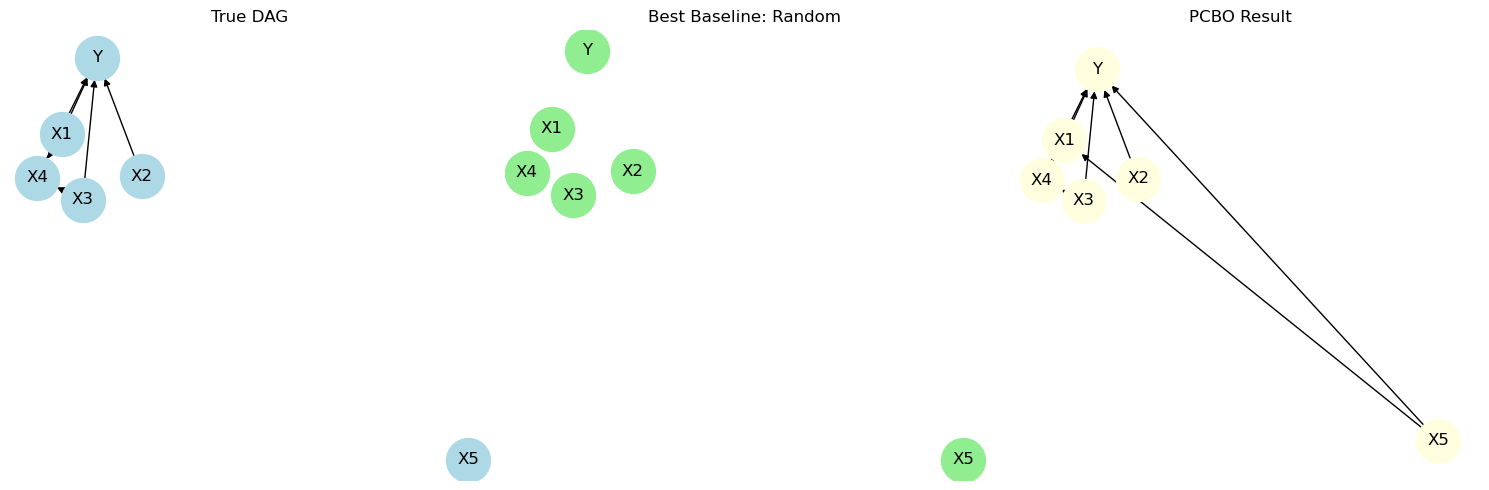


Note: These baselines use the intervention data but don't leverage
preference information, which is why PCBO should eventually outperform them
with proper tuning.


In [10]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# True graph
ax = axes[0]
G_true = nx.DiGraph(true_adj.numpy())
pos = nx.spring_layout(G_true, seed=42)
nx.draw(G_true, pos, ax=ax, with_labels=True, 
        labels={i: node_names[i] for i in range(n_nodes)},
        node_color='lightblue', node_size=1000, font_size=12)
ax.set_title("True DAG")

# Best baseline
ax = axes[1]
G_baseline = nx.DiGraph(best_baseline[1]['adj'])
nx.draw(G_baseline, pos, ax=ax, with_labels=True,
        labels={i: node_names[i] for i in range(n_nodes)},
        node_color='lightgreen', node_size=1000, font_size=12)
ax.set_title(f"Best Baseline: {best_baseline[0]}")

# PCBO result (using final learned adjacency)
ax = axes[2]
learned_adj = torch.zeros_like(true_adj)
for lp in pcbo.local_posts.values():
    mask, _ = lp.most_probable_set()
    for k, is_parent in enumerate(mask):
        if is_parent:
            src = lp.parent_idx[k]
            learned_adj[src, lp.target_idx] = 1
G_pcbo = nx.DiGraph(learned_adj.numpy())
nx.draw(G_pcbo, pos, ax=ax, with_labels=True,
        labels={i: node_names[i] for i in range(n_nodes)},
        node_color='lightyellow', node_size=1000, font_size=12)
ax.set_title("PCBO Result")

plt.tight_layout()
plt.show()

print("\nNote: These baselines use the intervention data but don't leverage")
print("preference information, which is why PCBO should eventually outperform them")
print("with proper tuning.")

## Visualize Results

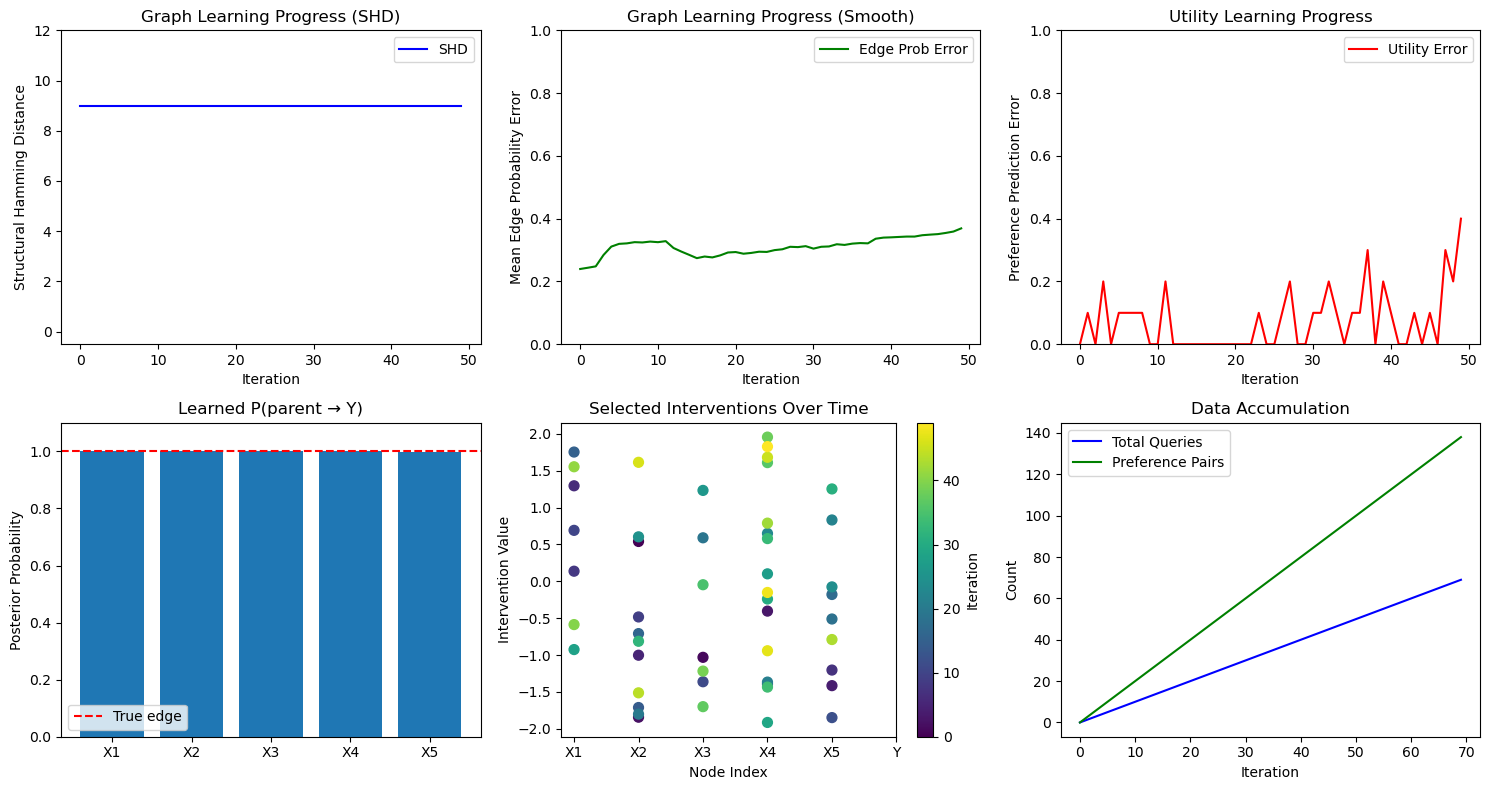

In [11]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# 1. Graph Learning Progress (SHD)
axes[0, 0].plot(pcbo.iteration_history, pcbo.graph_distances, 'b-', label='SHD')
axes[0, 0].set_xlabel("Iteration")
axes[0, 0].set_ylabel("Structural Hamming Distance")
axes[0, 0].set_title("Graph Learning Progress (SHD)")
axes[0, 0].set_ylim([-0.5, n_nodes * 2])
axes[0, 0].legend()

# 2. Edge Probability Error (Smoother metric)
axes[0, 1].plot(pcbo.iteration_history, pcbo.edge_prob_errors, 'g-', label='Edge Prob Error')
axes[0, 1].set_xlabel("Iteration")
axes[0, 1].set_ylabel("Mean Edge Probability Error")
axes[0, 1].set_title("Graph Learning Progress (Smooth)")
axes[0, 1].set_ylim([0, 1])
axes[0, 1].legend()

# 3. Utility Learning Progress
axes[0, 2].plot(pcbo.iteration_history, pcbo.utility_errors, 'r-', label='Utility Error')
axes[0, 2].set_xlabel("Iteration")
axes[0, 2].set_ylabel("Preference Prediction Error")
axes[0, 2].set_title("Utility Learning Progress")
axes[0, 2].set_ylim([0, 1])
axes[0, 2].legend()

# 4. Final Edge Probabilities
edge_probs = pcbo.parent_posterior.edge_posterior().cpu().numpy()
pnames = [pcbo.node_names[i] for i in pcbo.parent_posterior.parent_idx]
axes[1, 0].bar(pnames, edge_probs)
axes[1, 0].axhline(y=1.0, color='r', linestyle='--', label='True edge')
axes[1, 0].set_ylabel("Posterior Probability")
axes[1, 0].set_title(f"Learned P(parent → {pcbo.node_names[pcbo.parent_posterior.target_idx]})")
axes[1, 0].set_ylim([0, 1.1])
axes[1, 0].legend()

# 5. Selected Interventions Over Time
if len(pcbo.selected_interventions) > 0:
    interventions_array = np.array(pcbo.selected_interventions)
    scatter = axes[1, 1].scatter(
        interventions_array[:, 0], interventions_array[:, 1],
        c=range(len(interventions_array)), cmap='viridis', s=50
    )
    plt.colorbar(scatter, ax=axes[1, 1], label='Iteration')
else:
    axes[1, 1].text(0.5, 0.5, "No interventions yet",
                    ha='center', va='center', transform=axes[1, 1].transAxes)
axes[1, 1].set_xlabel("Node Index")
axes[1, 1].set_ylabel("Intervention Value")
axes[1, 1].set_title("Selected Interventions Over Time")
axes[1, 1].set_xticks(list(range(len(pcbo.node_names))))
axes[1, 1].set_xticklabels(pcbo.node_names)

# 6. Preference Dataset Growth
axes[1, 2].plot(range(len(all_queries)), [i for i in range(len(all_queries))], 'b-', label='Total Queries')
axes[1, 2].plot(range(len(all_queries)), [min(i*2, len(pcbo.pref_dataset)) for i in range(len(all_queries))], 
               'g-', label='Preference Pairs')
axes[1, 2].set_xlabel("Iteration")
axes[1, 2].set_ylabel("Count")
axes[1, 2].set_title("Data Accumulation")
axes[1, 2].legend()

plt.tight_layout()
plt.show()

## Final Results and Analysis


FINAL RESULTS

True causal graph:
[[0 0 0 1 0 1]
 [0 0 0 0 0 1]
 [0 0 0 1 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]

Most probable parent set for Y: (1, 1, 1, 1, 1)
Posterior probability: 0.999

Edge posterior probabilities:
  P(X1 -> Y) = 1.000
  P(X2 -> Y) = 1.000
  P(X3 -> Y) = 1.000
  P(X4 -> Y) = 1.000
  P(X5 -> Y) = 0.999

Final metrics:
  SHD: 9.00
  Edge probability error: 0.369
  Utility prediction error: 0.400

Learning efficiency:
  Total queries: 70
  Total preference comparisons: 220
  Flow reinitializations: 0


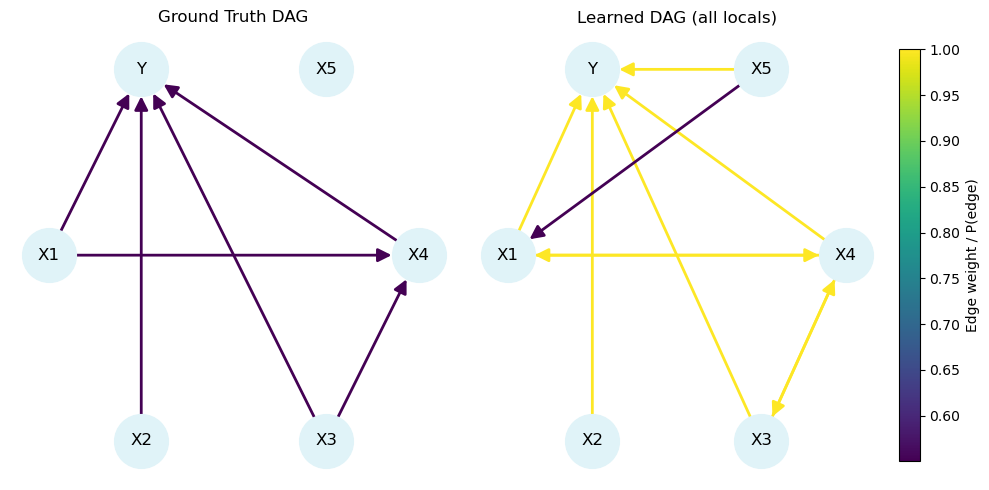

In [12]:
print("\n" + "="*50)
print("FINAL RESULTS")
print("="*50)

print(f"\nTrue causal graph:")
print(f"{true_adj.numpy()}")

most_prob_parents, prob = pcbo.parent_posterior.most_probable_set()
print(f"\nMost probable parent set for Y: {most_prob_parents}")
print(f"Posterior probability: {prob:.3f}")

edge_probs = pcbo.parent_posterior.edge_posterior()
print(f"\nEdge posterior probabilities:")
for j, pid in enumerate(pcbo.parent_posterior.parent_idx):
    print(f"  P({pcbo.node_names[pid]} -> {pcbo.node_names[pcbo.parent_posterior.target_idx]}) = {edge_probs[j]:.3f}")

print(f"\nFinal metrics:")
print(f"  SHD: {pcbo.graph_distances[-1]:.2f}")
print(f"  Edge probability error: {pcbo.edge_prob_errors[-1]:.3f}")
print(f"  Utility prediction error: {pcbo.utility_errors[-1]:.3f}")

print(f"\nLearning efficiency:")
print(f"  Total queries: {len(all_queries)}")
print(f"  Total preference comparisons: {len(pcbo.pref_dataset)}")
print(f"  Flow reinitializations: {pcbo.reinitialization_count}")

# ---- Build learned graph & edge-prob matrix from all locals ----
learned_adj_full = torch.zeros_like(true_adj)
P_full = np.zeros_like(true_adj.cpu().numpy(), dtype=float)

for tgt, lp in pcbo.local_posts.items():
    # MAP edges for adjacency
    mask, _ = lp.most_probable_set()
    for j, is_parent in enumerate(mask):
        if is_parent:
            src = lp.parent_idx[j]
            learned_adj_full[src, lp.target_idx] = 1

    # Posterior edge probabilities into this target
    probs = lp.edge_posterior().cpu().numpy()
    for j, src in enumerate(lp.parent_idx):
        P_full[src, lp.target_idx] = float(probs[j])

# ---- Plot: ground truth vs learned (full) ----
fig, (axL, axR) = plt.subplots(1, 2, figsize=(10, 5))
plot_dag(true_adj.numpy(), names=node_names, edge_probs=(true_adj.numpy() > 0).astype(float), ax=axL)
axL.set_title("Ground Truth DAG")

plot_dag(learned_adj_full.numpy(), names=node_names, edge_probs=P_full, ax=axR)
axR.set_title("Learned DAG (all locals)")
plt.tight_layout(); plt.show()

In [13]:
# Ensure the learned graph is a DAG
learned_dag = pcbo.get_learned_dag()
print(f"\nLearned graph is DAG: {is_dag(learned_adj_full.numpy())}")
if not is_dag(learned_adj_full.numpy()):
    print("Projected to DAG - removed cycles")
    learned_adj_full = torch.tensor(learned_dag)

  Graph has cycles, projecting to DAG...

Learned graph is DAG: False
Projected to DAG - removed cycles


In [14]:
def compute_comprehensive_metrics(true_adj, learned_adj, edge_probs):
    """Compute precision, recall, F1, AUC for edge discovery"""
    from sklearn.metrics import precision_recall_curve, auc, roc_auc_score
    
    # Flatten adjacency matrices
    true_edges = true_adj.cpu().numpy().flatten()
    learned_edges = learned_adj.cpu().numpy().flatten()
    edge_probs_flat = edge_probs.flatten()
    
    # Binary metrics
    tp = np.sum((true_edges == 1) & (learned_edges == 1))
    fp = np.sum((true_edges == 0) & (learned_edges == 1))
    fn = np.sum((true_edges == 1) & (learned_edges == 0))
    tn = np.sum((true_edges == 0) & (learned_edges == 0))
    
    precision = tp / (tp + fp + 1e-10)
    recall = tp / (tp + fn + 1e-10)
    f1 = 2 * precision * recall / (precision + recall + 1e-10)
    
    # ROC AUC
    if len(np.unique(true_edges)) > 1:
        auc_score = roc_auc_score(true_edges, edge_probs_flat)
    else:
        auc_score = 0.0
    
    # Precision-Recall curve
    precisions, recalls, _ = precision_recall_curve(true_edges, edge_probs_flat)
    pr_auc = auc(recalls, precisions)
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': auc_score,
        'pr_auc': pr_auc,
        'tp': tp, 'fp': fp, 'fn': fn, 'tn': tn
    }

# Add to evaluation
metrics = compute_comprehensive_metrics(true_adj, learned_adj_full, P_full)
print(f"\nComprehensive Metrics:")
for key, value in metrics.items():
    print(f"  {key}: {value:.3f}")


Comprehensive Metrics:
  precision: 0.750
  recall: 1.000
  f1: 0.857
  roc_auc: 0.983
  pr_auc: 0.925
  tp: 6.000
  fp: 2.000
  fn: 0.000
  tn: 28.000


### Show Only High-Confidence Edges


High-confidence edges (P >= 0.9995):
  X1 → X4   (P = 1.0000)
  X1 → Y   (P = 1.0000)
  X2 → Y   (P = 0.9996)
  X3 → X4   (P = 1.0000)
  X3 → Y   (P = 1.0000)
  X4 → X1   (P = 1.0000)
  X4 → X3   (P = 1.0000)
  X4 → Y   (P = 1.0000)

High-confidence parents of Y (P >= 0.9995):
  X1 -> Y   (P = 1.0000)
  X2 -> Y   (P = 0.9996)
  X3 -> Y   (P = 1.0000)
  X4 -> Y   (P = 1.0000)


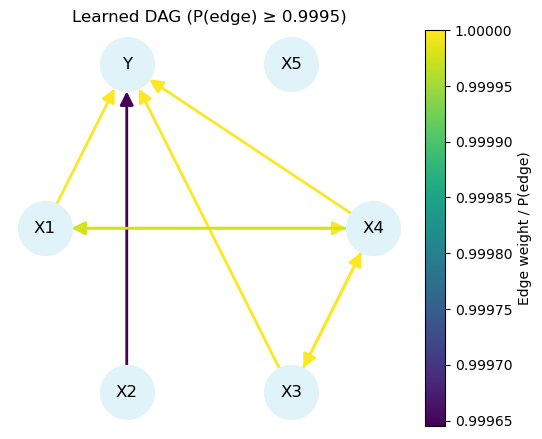

In [15]:
threshold = 0.9995

# Use the edge-prob matrix we already built above (P_full)
P_thresh = P_full.copy()
adj_thresh = (P_thresh >= threshold).astype(int)

# No self-loops
np.fill_diagonal(adj_thresh, 0)

kept = []
for i in range(adj_thresh.shape[0]):
    for j in range(adj_thresh.shape[1]):
        if adj_thresh[i, j] == 1:
            kept.append((pcbo.node_names[i], pcbo.node_names[j], P_thresh[i, j]))

print("\nHigh-confidence edges (P >= {:.4f}):".format(threshold))
if kept:
    for src, tgt, p in kept:
        print(f"  {src} → {tgt}   (P = {p:.4f})")
else:
    print("  (none)")

if hasattr(pcbo, "parent_posterior"):
    y_idx = pcbo.parent_posterior.target_idx
    print("\nHigh-confidence parents of {} (P >= {:.4f}):".format(pcbo.node_names[y_idx], threshold))
    found = False
    for i in range(adj_thresh.shape[0]):
        if adj_thresh[i, y_idx] == 1:
            print(f"  {pcbo.node_names[i]} -> {pcbo.node_names[y_idx]}   (P = {P_thresh[i, y_idx]:.4f})")
            found = True
    if not found:
        print("  (none)")

fig, ax = plt.subplots(1, 1, figsize=(5.5, 4.5))
plot_dag(torch.tensor(adj_thresh), names=pcbo.node_names, edge_probs=P_thresh, ax=ax)
ax.set_title(f"Learned DAG (P(edge) ≥ {threshold:.4f})")
plt.tight_layout()
plt.show()